In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
!pip install anndata


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 2.5 MB/s eta 0:00:00


In [3]:
!pip install scanpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.9 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82813 sha256=ad8e5bb81191bb10b3e14d57a820cb330d6e990b9007f26c3646da0ed31a64d1
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=196972197c208f0c25fb15aad8f6620f750600fb190989b1dd0bdc6fff262758
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
  Created wheel for pynnd

In [4]:
import anndata

file_path = "/content/gdrive/MyDrive/cortex.h5ad"
adata = anndata.read_h5ad(file_path)
print(adata)

num_cells = adata.n_obs
num_cell_types = adata.obs['label'].nunique()
num_genes = adata.n_vars

print(f"Number of cells: {num_cells}")
print(f"Number of cell types: {num_cell_types}")
print(f"Number of genes: {num_genes}")

AnnData object with n_obs × n_vars = 3005 × 19972
    obs: 'cell_ids', 'label', 'label2'
    var: 'genes'
Number of cells: 3005
Number of cell types: 7
Number of genes: 19972


In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc


In [ ]:
adata

AnnData object with n_obs × n_vars = 3005 × 19972
    obs: 'cell_ids', 'label', 'label2'
    var: 'genes'

# Preprocessing

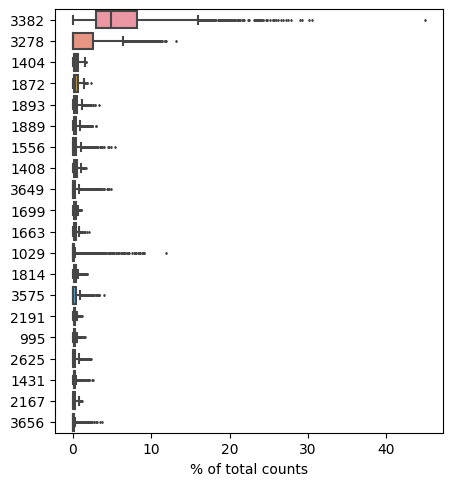

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [ ]:
# BAsic filtering, No need as in the instruction it was given that don't filter cells

''' sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=10)
'''

' sc.pp.filter_cells(adata, min_genes=200)\nsc.pp.filter_genes(adata, min_cells=10)\n'

In [ ]:
adata.var['mt'] = None


In [ ]:
adata.var_names

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '19962', '19963', '19964', '19965', '19966', '19967', '19968', '19969',
       '19970', '19971'],
      dtype='object', length=19972)

In [ ]:
adata.n_obs

3005

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)


In [ ]:
sc.pp.log1p(adata)


In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

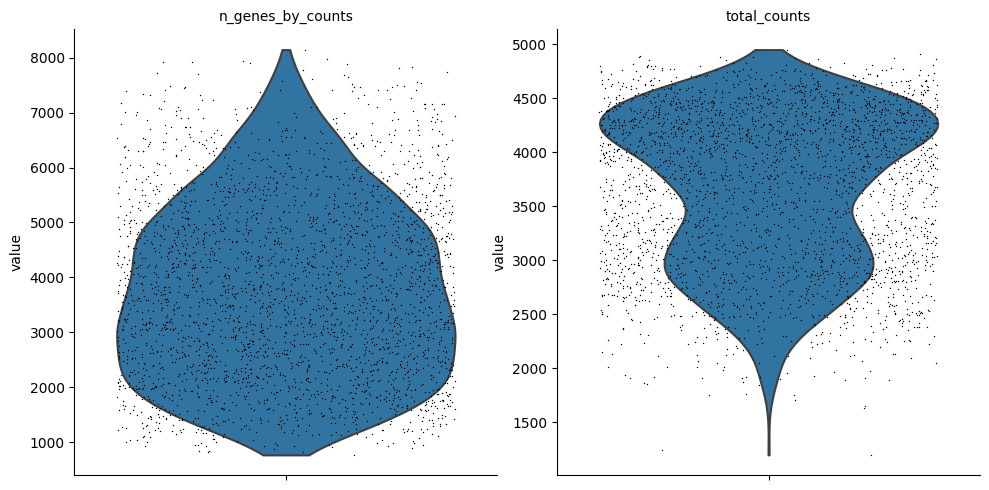

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

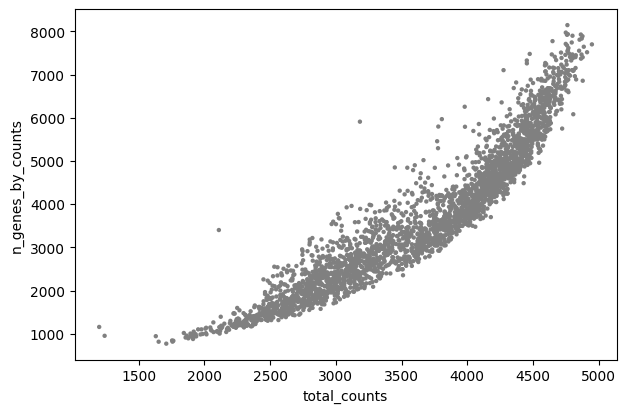

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

# Training a VAE

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import umap

In [ ]:
adata = anndata.read_h5ad('/content/gdrive/MyDrive/cortex.h5ad')
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
genes_data = adata.X

In [ ]:
label_encoder = LabelEncoder()
cell_labels = label_encoder.fit_transform(adata.obs['label'])

# Converting the data to PyTorch tensors
genes_data = torch.tensor(genes_data, dtype=torch.float32)
cell_labels = torch.tensor(cell_labels, dtype=torch.long)

In [ ]:
class NegativeBinomialLoss(nn.Module):
    def __init__(self, eps=1e-8):
        super(NegativeBinomialLoss, self).__init__()
        self.eps = eps

    def forward(self, preds, targets):
        mean = preds
        alpha = torch.exp(torch.log(mean + self.eps) - torch.log(targets + self.eps))
        beta = alpha / (mean + self.eps)
        loss = -torch.lgamma(alpha + targets) + torch.lgamma(alpha) + targets * torch.log(beta + self.eps) \
               + alpha * torch.log(mean + self.eps) - alpha * torch.log(beta + self.eps)
        return loss.mean()

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
def train_vae(vae, train_loader, optimizer, criterion, epochs=50):
    vae.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, data in enumerate(train_loader):
            data = data[0].to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(data)
            loss = criterion(recon_batch, data)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader.dataset):.4f}")


In [ ]:
# Hyperparameters
input_dim = genes_data.shape[1]
hidden_dim = 256
latent_dim = 2
batch_size = 64
learning_rate = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=0.01)
criterion = NegativeBinomialLoss()

train_dataset = TensorDataset(genes_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_vae(vae, train_loader, optimizer, criterion, epochs=50)


Epoch 1, Loss: -23153360.6336
Epoch 2, Loss: -23397419.2346
Epoch 3, Loss: -23397917.6466
Epoch 4, Loss: -23397682.4759
Epoch 5, Loss: -23397726.2642
Epoch 6, Loss: -23397742.4080
Epoch 7, Loss: -23397811.4982
Epoch 8, Loss: -23398191.0256
Epoch 9, Loss: -23397193.4349
Epoch 10, Loss: -23397960.9664
Epoch 11, Loss: -23397452.4592
Epoch 12, Loss: -23397252.7707
Epoch 13, Loss: -23398433.3950
Epoch 14, Loss: -23397680.9850
Epoch 15, Loss: -23398280.6043
Epoch 16, Loss: -23397807.8349
Epoch 17, Loss: -23397978.0473
Epoch 18, Loss: -23398597.0476
Epoch 19, Loss: -23397476.5684
Epoch 20, Loss: -23397979.4955
Epoch 21, Loss: -23397838.6742
Epoch 22, Loss: -23398026.4359
Epoch 23, Loss: -23397817.2060
Epoch 24, Loss: -23397796.0785
Epoch 25, Loss: -23398204.0173
Epoch 26, Loss: -23397664.5431
Epoch 27, Loss: -23397664.6709
Epoch 28, Loss: -23398118.1018
Epoch 29, Loss: -23397615.1321
Epoch 30, Loss: -23398253.7265
Epoch 31, Loss: -23397964.7574
Epoch 32, Loss: -23398435.2692
Epoch 33, Loss: -

In [ ]:
import umap
import matplotlib.pyplot as plt

# Extract latent variables for each cell
vae.eval()
with torch.no_grad():
    genes_data = genes_data.to(device)
    latent_vars = vae.encode(genes_data)[0].cpu().numpy()

# dimensionality reduction
reducer = umap.UMAP(n_components=2)
latent_2d = reducer.fit_transform(latent_vars)


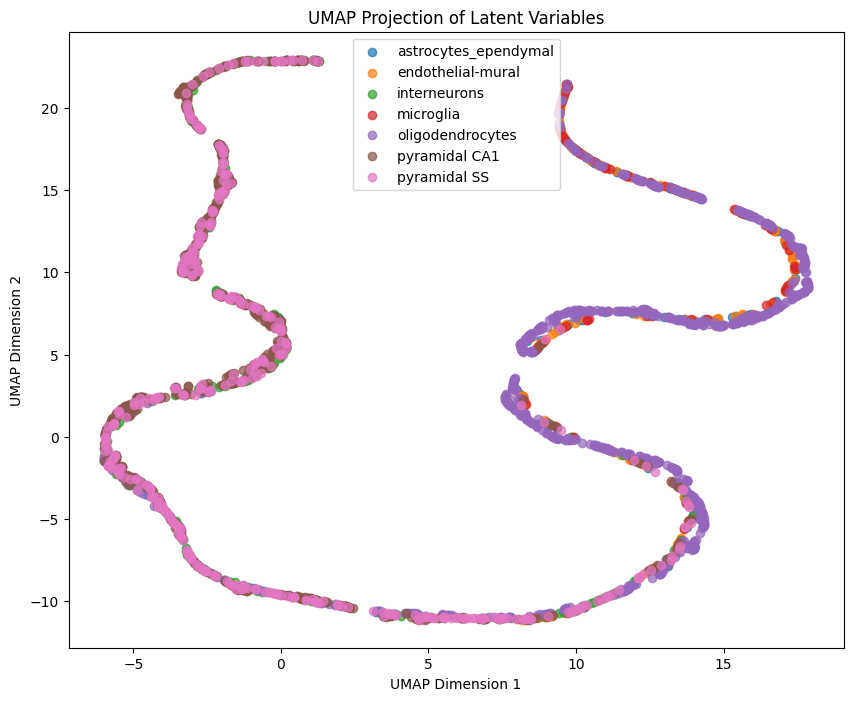

In [ ]:
cell_type_labels = adata.obs['label']

plt.figure(figsize=(10, 8))
for cell_type in np.unique(cell_type_labels):
    mask = cell_type_labels == cell_type
    plt.scatter(latent_2d[mask, 0], latent_2d[mask, 1], label=cell_type, alpha=0.7)

plt.title("UMAP Projection of Latent Variables")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend()
plt.show()


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

num_clusters = len(label_encoder.classes_)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(latent_vars)

ari_score = adjusted_rand_score(cell_labels, kmeans_labels)
print(f"ARI Score: {ari_score:.4f}")


ARI Score: 0.2015


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score

num_clusters = len(label_encoder.classes_)
agglomerative_clustering = AgglomerativeClustering(n_clusters=num_clusters)

agglomerative_labels = agglomerative_clustering.fit_predict(latent_vars)
ari_score = adjusted_rand_score(cell_labels, agglomerative_labels)
print(f"ARI Score with Agglomerative Clustering: {ari_score:.4f}")


ARI Score with Agglomerative Clustering: 0.2119


# Retraining VAE by finding highly variable genes

In [30]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import umap

adata = anndata.read_h5ad('/content/gdrive/MyDrive/cortex.h5ad')
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
genes_data = adata.X

label_encoder = LabelEncoder()
cell_labels = label_encoder.fit_transform(adata.obs['label'])

genes_data = torch.tensor(genes_data, dtype=torch.float32)
cell_labels = torch.tensor(cell_labels, dtype=torch.long)


class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

from sklearn.feature_selection import VarianceThreshold

variance_threshold = VarianceThreshold()
variance_threshold.fit(genes_data)

threshold_value = 0.6

highly_variable_genes_indices = np.where(variance_threshold.variances_ > threshold_value)[0]

# Hyperparameters
input_dim = genes_data.shape[1]
hidden_dim = 256
latent_dim = 10
batch_size = 64
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class WeightedNegativeBinomialLoss(nn.Module):
    def __init__(self, gene_weights, eps=1e-8):
        super(WeightedNegativeBinomialLoss, self).__init__()
        self.eps = eps
        self.gene_weights = gene_weights

    def forward(self, preds, targets):
        mean = preds
        alpha = torch.exp(torch.log(mean + self.eps) - torch.log(targets + self.eps))
        beta = alpha / (mean + self.eps)

        gene_loss = -torch.lgamma(alpha + targets) + torch.lgamma(alpha) + targets * torch.log(beta + self.eps) \
                    + alpha * torch.log(mean + self.eps) - alpha * torch.log(beta + self.eps)
        weighted_loss = torch.sum(self.gene_weights * gene_loss, dim=1)

        return weighted_loss.mean()

def train_vae_with_weighted_loss(vae, train_loader, optimizer, criterion, epochs=50):
    vae.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, data in enumerate(train_loader):
            data = data[0].to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(data)
            loss = criterion(recon_batch, data)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader.dataset):.4f}")

gene_weights = torch.ones(input_dim, dtype=torch.float32, device=device)
gene_weights[highly_variable_genes_indices] = 3.0
vae = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

# Use the WeightedNegativeBinomialLoss for training
weighted_criterion = WeightedNegativeBinomialLoss(gene_weights)

# Train the VAE again with the adjusted loss
train_vae_with_weighted_loss(vae, train_loader, optimizer, weighted_criterion, epochs=50)


Epoch 1, Loss: -331465551628.0120
Epoch 2, Loss: -403896109112.5671
Epoch 3, Loss: -412314791877.3884
Epoch 4, Loss: -416173040005.8356
Epoch 5, Loss: -418932233232.0160
Epoch 6, Loss: -419792819270.5385
Epoch 7, Loss: -420201866500.0040
Epoch 8, Loss: -421087063541.9474
Epoch 9, Loss: -421932960443.9321
Epoch 10, Loss: -422425230062.3654
Epoch 11, Loss: -422598507159.1295
Epoch 12, Loss: -423133051314.1351
Epoch 13, Loss: -423780575781.9954
Epoch 14, Loss: -424337240179.8602
Epoch 15, Loss: -424762264148.3394
Epoch 16, Loss: -425149056442.6542
Epoch 17, Loss: -425569133086.4985
Epoch 18, Loss: -425766645723.1973
Epoch 19, Loss: -425886015894.1923
Epoch 20, Loss: -426164198745.1953
Epoch 21, Loss: -426668350596.5577
Epoch 22, Loss: -426848825007.3238
Epoch 23, Loss: -427006049295.3345
Epoch 24, Loss: -427263749845.4895
Epoch 25, Loss: -427318670103.9388
Epoch 26, Loss: -427512991301.0050
Epoch 27, Loss: -427570644486.9857
Epoch 28, Loss: -427612260915.6260
Epoch 29, Loss: -427642878636

In [24]:
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

vae.eval()
with torch.no_grad():
    latent_space = vae.encode(genes_data.to(device))[0].cpu().numpy()

n_clusters = len(np.unique(cell_labels))
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(latent_space)
predicted_labels = kmeans.labels_

ari_score = adjusted_rand_score(cell_labels, predicted_labels)

print(f"Adjusted Rand Index (ARI) Score: {ari_score:.4f}")


Adjusted Rand Index (ARI) Score: 0.1988


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# VAE using KL Divergence Loss

In [11]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import umap
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.feature_selection import VarianceThreshold

adata = anndata.read_h5ad('/content/gdrive/MyDrive/cortex.h5ad')
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
genes_data = adata.X

label_encoder = LabelEncoder()
cell_labels = label_encoder.fit_transform(adata.obs['label'])
genes_data = torch.tensor(genes_data, dtype=torch.float32)
cell_labels = torch.tensor(cell_labels, dtype=torch.long)
variance_threshold = VarianceThreshold()
variance_threshold.fit(genes_data)
threshold_value = 0.5

highly_variable_genes_indices = np.where(variance_threshold.variances_ > threshold_value)[0]

class VAEWithRegularization(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAEWithRegularization, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def train_vae_with_kl_regularization(vae, train_loader, optimizer, kl_weight=2.0, epochs=50):
    vae.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, data in enumerate(train_loader):
            data = data[0].to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(data)

            reconstruction_loss = F.binary_cross_entropy(recon_batch, data, reduction='sum')
            kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

            loss = reconstruction_loss + kl_weight * kl_divergence
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader.dataset):.4f}")


# Hyperparameters
input_dim = genes_data.shape[1]
hidden_dim = 512
latent_dim = 10
batch_size = 64
learning_rate = 1e-3
kl_weight = 0.01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae_with_kl = VAEWithRegularization(input_dim, hidden_dim, latent_dim).to(device)
optimizer_with_kl = torch.optim.Adam(vae_with_kl.parameters(), lr=learning_rate)

train_dataset = TensorDataset(genes_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_vae_with_kl_regularization(vae_with_kl, train_loader, optimizer_with_kl, kl_weight, epochs=50)

vae_with_kl.eval()

with torch.no_grad():
    latent_space = vae_with_kl.encode(genes_data.to(device))[0].cpu().numpy()

n_clusters = len(np.unique(cell_labels))
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(latent_space)
predicted_labels = kmeans.labels_

ari_score = adjusted_rand_score(cell_labels, predicted_labels)

print(f"Adjusted Rand Index (ARI) Score: {ari_score:.4f}")


Epoch 1, Loss: -16288.5346
Epoch 2, Loss: -30703.0351
Epoch 3, Loss: -34041.9556
Epoch 4, Loss: -35340.6616
Epoch 5, Loss: -36097.3950
Epoch 6, Loss: -36611.7545
Epoch 7, Loss: -37015.4099
Epoch 8, Loss: -37346.1381
Epoch 9, Loss: -37634.8086
Epoch 10, Loss: -37878.2109
Epoch 11, Loss: -38040.4970
Epoch 12, Loss: -38240.9626
Epoch 13, Loss: -38392.5672
Epoch 14, Loss: -38532.6646
Epoch 15, Loss: -38643.6007
Epoch 16, Loss: -38780.2621
Epoch 17, Loss: -38892.1300
Epoch 18, Loss: -38984.8680
Epoch 19, Loss: -39084.5752
Epoch 20, Loss: -39182.9928
Epoch 21, Loss: -39293.2833
Epoch 22, Loss: -39388.6808
Epoch 23, Loss: -39475.6235
Epoch 24, Loss: -39533.0080
Epoch 25, Loss: -39618.0329
Epoch 26, Loss: -39689.2686
Epoch 27, Loss: -39762.7000
Epoch 28, Loss: -39847.2458
Epoch 29, Loss: -39897.5077
Epoch 30, Loss: -39995.1114
Epoch 31, Loss: -40058.2191
Epoch 32, Loss: -40132.6318
Epoch 33, Loss: -40193.4834
Epoch 34, Loss: -40262.7741
Epoch 35, Loss: -40312.4374
Epoch 36, Loss: -40381.1834
E

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<ipython-input-12-5ea38cc9af95>:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(umap_latent[mask, 0], umap_latent[mask, 1], c=label_colors[label], label=f'Cell Type {label}', s=30)


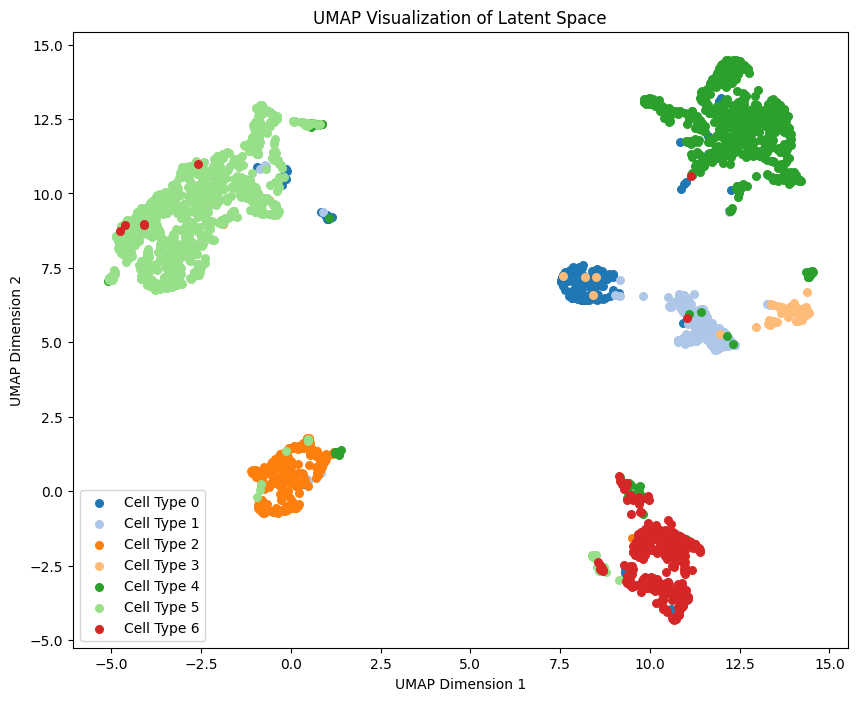

In [12]:
import umap
import matplotlib.pyplot as plt

umap_reducer = umap.UMAP()
umap_latent = umap_reducer.fit_transform(latent_space)

unique_labels = np.unique(cell_labels)

label_colors = {}
for label in unique_labels:
    label_colors[label] = plt.cm.tab20(label)

plt.figure(figsize=(10, 8))
for i, label in enumerate(unique_labels):
    mask = (cell_labels == label)
    plt.scatter(umap_latent[mask, 0], umap_latent[mask, 1], c=label_colors[label], label=f'Cell Type {label}', s=30)

plt.title('UMAP Visualization of Latent Space')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()




